In [1]:
import os, os.path
import numpy as np
import pandas as pd
import data_structures as ds
import model_afolu as ma
import model_ippu as mi
import model_circular_economy as mc
import model_energy as me
import model_socioeconomic as se
from model_socioeconomic import Socioeconomic
import setup_analysis as sa
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt

importlib.reload(ds)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(ma)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:721: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:721: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


<module 'model_socioeconomic' from '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_socioeconomic.py'>

In [12]:
importlib.reload(ds)
importlib.reload(sa)
importlib.reload(ma)

# load latest data
df_base_inputs =  pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))
df_input_data = pd.read_csv("/Users/jsyme/Downloads/data_complete_future_2022_07_31_test.csv")
df_mean_transition_0 = pd.read_csv(sa.fp_csv_transition_probability_estimation_mean.replace(".csv", "tmp.csv"))
# set up some required components
optimization_approach = "max_diagonal"
all_countries = sorted(list(set(df_input_data["Nation"])))
# initialize the model
model_afolu = ma.AFOLU(sa.model_attributes)

crop_area_total = 0.0
t_0 = time.time()
warnings.filterwarnings("ignore")

for country in all_countries:
    # filter and prepare
    df_input = df_input_data[df_input_data["Nation"] == country].reset_index(drop = True).copy();
    df_cat = df_base_inputs[[x for x in df_base_inputs.columns if x not in df_input.columns]]
    df_input = pd.concat([df_input, df_cat], axis = 1)

    # update some fields
    df_input["frac_agrc_initial_yield_feed_sugar_cane"] = 0
    df_input["lndu_reallocation_factor"] = 1
    df_input["elasticity_agrc_sugar_cane_demand_to_income"] = 0.05

    # update transitions
    fields_ow = []
    df_mean_transition = df_mean_transition_0[
        df_mean_transition_0["country"].isin([country]) & 
        df_mean_transition_0["optimization_bound"].isin([optimization_approach])
    ].copy().reset_index(drop = True)
    cols_loop = [x for x in df_mean_transition.columns if (x not in ["country", "year", "optimization_bound"])]
    for k in cols_loop:
        k_new = f"pij_lndu_{k}"
        if k_new in df_input.columns:
            df_input[k_new] = float(df_mean_transition[k])
            fields_ow.append(k_new)

    # update crop area total
    df_output = model_afolu.project(df_input)
    crop_area_total += np.sum(sa.model_attributes.get_standard_variables(df_output, model_afolu.modvar_agrc_area_crop, "array_base"), axis = 1)
    
    t_cur = time.time()
    t_elapse = np.round(t_cur - t_0, 2)
    print(f"Country {country} complete.\n\tTotal time: {t_elapse} seconds\n")
    



Country argentina complete.
	Total time: 0.45 seconds

Country bahamas complete.
	Total time: 0.82 seconds

Country barbados complete.
	Total time: 1.6 seconds

Country belize complete.
	Total time: 2.44 seconds

Country bolivia complete.
	Total time: 2.81 seconds

Country brazil complete.
	Total time: 3.15 seconds

Country chile complete.
	Total time: 3.52 seconds

Country colombia complete.
	Total time: 3.91 seconds

Country costa_rica complete.
	Total time: 4.31 seconds

Country dominican_republic complete.
	Total time: 5.19 seconds

Country ecuador complete.
	Total time: 5.62 seconds

Country el_salvador complete.
	Total time: 5.94 seconds

Country guatemala complete.
	Total time: 6.77 seconds

Country guyana complete.
	Total time: 7.41 seconds

Country haiti complete.
	Total time: 7.74 seconds

Country honduras complete.
	Total time: 8.2 seconds

Country jamaica complete.
	Total time: 9.06 seconds

Country mexico complete.
	Total time: 9.46 seconds

Country nicaragua complete.
	To

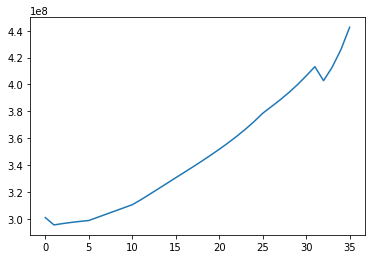

In [14]:
plt.plot(crop_area_total)

In [7]:
df_mean_transition["country"]

Series([], Name: country, dtype: object)

In [ ]:
print(df_output[[x for x in df_output.columns if (("emission_co2e" in x) and (("agrc" in x) or ("frst" in x)))]]["emission_co2e_co2_agrc_soil_carbon_mineral_soils"].head())
df_output[[x for x in df_output.columns if (("emission_co2e" in x) and (("agrc" in x) or ("frst" in x)))]]["emission_co2e_co2_agrc_soil_carbon_mineral_soils"].plot()
